In [1]:
# all within Gujarat
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import argparse
import data_input_jpg as dataset
import json

from haversine import haversine

In [2]:
def dist(lat1, lon1, lat2, lon2):
    return np.sqrt(np.square(lat2 - lat1) + np.square(lon2 - lon1))

with open("gujarat-water-filtered.json", "r") as gujfile:
    water_bodies = json.load(gujfile)

print("Num water bodies:", len(water_bodies))

def num_nearby_water_bodies(lat, lon, radius_km, wb_times_within_boundary):
    count = 0
    boundary = float(radius_km)+7 # add 1km boundary
    for wb in water_bodies:
        dist_km = haversine((lat, lon), (wb[0], wb[1]))
        if dist_km < boundary:
            count += 1
            if str(wb) not in wb_times_within_boundary:
                wb_times_within_boundary[str(wb)] = 0.0
            wb_times_within_boundary[str(wb)] += 1.0
    return count

def radius(area):
    """
    Get radius of circle with given area
    """
    return np.sqrt(area / np.pi)

villages = np.load("openstreetmap/gujarat_villages.npy")
print("total villages:", len(villages))
examples = dict()
village_ids = []
wb_times_within_boundary = dict()
for idx, village in enumerate(villages):
    vid = int(village[1])
    village_ids.append(vid)
    
    area = float(village[5]) / 10**6 # convert to km^2 from m^2
    lat = float(village[7])
    lon = float(village[6])
    num_wb = num_nearby_water_bodies(lat, lon, radius(area), wb_times_within_boundary)
    if idx % 500 == 0:
        print("on village num", idx, "with id:", vid, "and water bodies:", num_wb)
    examples[vid] = {"y": num_wb}

Num water bodies: 2605
total villages: 12678
on village num 0 with id: 442056 and water bodies: 0
on village num 500 with id: 442642 and water bodies: 0
on village num 1000 with id: 443176 and water bodies: 0
on village num 1500 with id: 443707 and water bodies: 1
on village num 2000 with id: 444215 and water bodies: 0
on village num 2500 with id: 444723 and water bodies: 0
on village num 3000 with id: 445244 and water bodies: 20
on village num 3500 with id: 445778 and water bodies: 1
on village num 4000 with id: 446287 and water bodies: 2
on village num 4500 with id: 446809 and water bodies: 2
on village num 5000 with id: 447338 and water bodies: 5
on village num 5500 with id: 447844 and water bodies: 7
on village num 6000 with id: 448359 and water bodies: 6
on village num 6500 with id: 448865 and water bodies: 1
on village num 7000 with id: 449382 and water bodies: 8
on village num 7500 with id: 450653 and water bodies: 0
on village num 8000 with id: 451596 and water bodies: 0
on vil

repeating 2223 out of 2223


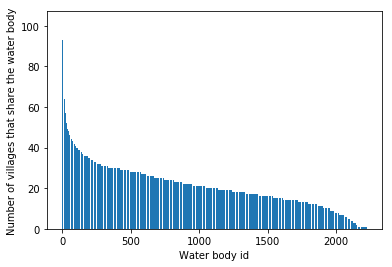

21.1124606388


In [3]:
repetitions = []
found = 0
for wb, count in wb_times_within_boundary.items():
    if count > 0.0:
        repetitions.append(count)
        found += 1
print("repeating", found, "out of", len(wb_times_within_boundary))

repetitions.sort(reverse=True)

plt.bar(list(range(len(wb_times_within_boundary))), repetitions)
plt.xlabel("Water body id")
plt.ylabel("Number of villages that share the water body")
plt.show()

print(np.mean(repetitions))

In [4]:
import tensorflow as tf
sess = tf.Session()
ANNOS_CSV = "/home/timhu/dfd-pop/data/annos_csv/state24_jpgpaths_density_nolaps_12k_Mar6.csv"
JPG_DIR = '/home/timhu/all_jpg/'
FLAGS = argparse.Namespace(batch_size= 1000,
                           output_size = 1) # embedding size or class number
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224
IMAGE_CHANNEL = 3
DATA = 's1'

df_annos = pd.read_csv(ANNOS_CSV, index_col=0)

if DATA == 'l8':
    path_col = ['l8_vis_jpg']
elif DATA == 's1':
    path_col = ['s1_vis_jpg']
elif DATA == 'l8s1':
    path_col = ['l8_vis_jpg', 's1_vis_jpg']

input_files_train = JPG_DIR + df_annos.loc[df_annos.partition == 'train', path_col].values
input_files_val = JPG_DIR + df_annos.loc[df_annos.partition == 'val', path_col].values
input_files_test = JPG_DIR + df_annos.loc[df_annos.partition == 'test', path_col].values
input_files = np.concatenate((input_files_train, input_files_val, input_files_test), axis=0)

input_labels_train = df_annos.loc[df_annos.partition == 'train', 'pop_density_log2'].values
input_labels_val = df_annos.loc[df_annos.partition == 'val', 'pop_density_log2'].values
input_labels_test = df_annos.loc[df_annos.partition == 'test', 'pop_density_log2'].values
input_labels = np.concatenate((input_labels_train, input_labels_val, input_labels_test), axis=0)

input_ids_train = df_annos.loc[df_annos.partition == 'train', 'village_id'].values
input_ids_val = df_annos.loc[df_annos.partition == 'val', 'village_id'].values
input_ids_test = df_annos.loc[df_annos.partition == 'test', 'village_id'].values
input_ids = np.concatenate((input_ids_train, input_ids_val, input_ids_test), axis=0)

images_batch, _, ids_batch = \
        dataset.input_batches(FLAGS.batch_size, FLAGS.output_size, input_files, input_labels, input_ids,
                              IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL, regression=True, augmentation=False, normalization=False, repeat=False)

saved = 0
def extract(examples, curr_im_batch, curr_ids_batch):
    s = 0
    for idx, vid in enumerate(curr_ids_batch):
        if vid in examples:
            examples[vid]["X"] = curr_im_batch[idx]
            s += 1
    return s

count = 0
while True:
    count += 1
    try:
        curr_images_batch, curr_ids_batch = sess.run([images_batch, ids_batch])
        saved += extract(examples, curr_images_batch, curr_ids_batch)
        print("finished batch", count)
    except tf.errors.OutOfRangeError:
        break

print("saved pics for num villages:", saved)

finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
saved pics for num villages: 12678


In [5]:
from sklearn.model_selection import train_test_split

images = []
y = []
vids = []

for vid, data in examples.items():
    if "X" not in data:
        continue
    vids.append(vid)
    images.append(data["X"])
    y.append(data["y"])

images_train, images_test, y_train, y_test, vids_train, vids_test = train_test_split(np.array(images), np.array(y), np.array(vids), test_size=0.1, random_state=42)
print(images_train.shape)
print(y_train.shape)
print(vids_train.shape)

(11410, 224, 224, 3)
(11410,)
(11410,)


In [6]:
import cv2
from sklearn.cluster import KMeans

num_real_train = int(len(images_train)*(7/9.0))

images_real_train = images_train[:num_real_train]
images_val = images_train[num_real_train:]
y_real_train = y_train[:num_real_train]
y_val = y_train[num_real_train:]
vids_real_train = vids_train[:num_real_train]
vids_val = vids_train[num_real_train:]

def compute_descriptors(X, y, vids):
    descriptors_by_idx = dict()
    final_X = []
    final_y = []
    final_vids = []
    for idx, img in enumerate(X):
        if idx % 500 == 0:
            print("on img", idx)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp = sift.detect(gray,None)
        kp,des = sift.compute(gray,kp)
        if des is None:
            continue
        descriptors_by_idx[idx] = {"X": des, "y": y[idx], "vid": vids[idx], "kp": kp, "gray": gray, "im": img}
    return descriptors_by_idx

print("Computing SIFT descriptors from", len(images_real_train), "train images...")
train_descriptors_by_idx = compute_descriptors(images_real_train, y_real_train, vids_real_train)

print("Computing SIFT descriptors from", len(images_val), "val images...")
val_descriptors_by_idx = compute_descriptors(images_val, y_val, vids_val)

Computing SIFT descriptors from 8874 train images...
on img 0
on img 500
on img 1000
on img 1500
on img 2000
on img 2500
on img 3000
on img 3500
on img 4000
on img 4500
on img 5000
on img 5500
on img 6000
on img 6500
on img 7000
on img 7500
on img 8000
on img 8500
Computing SIFT descriptors from 2536 val images...
on img 0
on img 500
on img 1000
on img 1500
on img 2000
on img 2500


In [7]:
feature_vector_len = 15

# now compute SIFT descriptors for all of the ones in train and cluster them
def cluster(descriptors):
    kmeans = KMeans(n_clusters=feature_vector_len, random_state=0).fit(descriptors)
    return kmeans

train_descriptors = []
for idx, data in train_descriptors_by_idx.items():
    train_descriptors.extend(data["X"])
print("Clustering", len(train_descriptors), "train descriptors into", str(feature_vector_len) ,"clusters...")
clusters = cluster(np.array(train_descriptors))

Clustering 2711800 train descriptors into 15 clusters...


In [50]:
# now compute feature vectors for everything in X_sift_train and X_sift_val
def compute_feature_vectors(clusters, descriptors_by_idx):
    feature_vectors = []
    ylog2 = []
    y = []
    vids = []
    kps = []
    imgs = []
    grays = []
    for idx, data in descriptors_by_idx.items():
        des = data["X"]
        kp = data["kp"]
        kp_by_cluster = dict()
        histogram = np.zeros((feature_vector_len))
        predicted_clusters = clusters.predict(des)
        for idx2, cluster_num in enumerate(predicted_clusters):
            histogram[cluster_num] += 1
            currkp = kp[idx2]
            if cluster_num not in kp_by_cluster:
                kp_by_cluster[cluster_num] = []
            kp_by_cluster[cluster_num].append(currkp)
        feature_vectors.append(histogram)
        
        ylog2.append(np.log2(data["y"]+1.0))
        y.append(data["y"])
        vids.append(data["vid"])
        imgs.append(data["im"])
        grays.append(data["gray"])
        kps.append(list(kp_by_cluster.items()))
    return np.array(feature_vectors), np.array(ylog2), np.array(y), np.array(vids), kps, imgs, grays

print("Computing feature vectors for", len(images_real_train), "training images...")
images_real_train_vecs, images_train_y_vecs, images_train_ynormal_vecs, images_train_vids, images_train_kps, images_train_imgs, images_train_grays = compute_feature_vectors(clusters, train_descriptors_by_idx)
assert images_real_train_vecs.shape == (len(train_descriptors_by_idx), feature_vector_len)

print("Computing feature vectors for", len(images_val), "validation images...")
images_val_vecs, images_val_y_vecs, images_val_ynormal_vecs, images_val_vids, images_val_kps, images_val_imgs, images_val_grays = compute_feature_vectors(clusters, val_descriptors_by_idx)
assert images_val_vecs.shape == (len(val_descriptors_by_idx), feature_vector_len)

Computing feature vectors for 8874 training images...
Computing feature vectors for 2536 validation images...


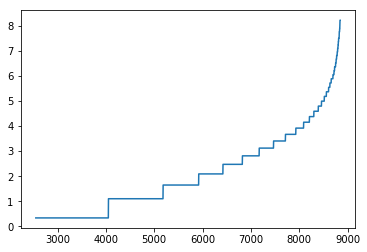

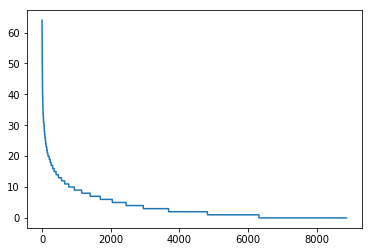

In [60]:
import scipy

cp = images_train_ynormal_vecs[:]
cdfy = scipy.stats.expon.cdf(np.sort(cp))
ret = scipy.stats.norm.ppf(cdfy) # a normal distribution
plt.plot(list(range(len(ret))), ret)
plt.show()

cp = images_train_ynormal_vecs[:]
cp.sort()
cp = list(cp)
cp.reverse()

plt.plot(list(range(len(cp))), cp)
plt.show()

In [ ]:
# pick some training image, and plot it's kps by cluster
select_kp = images_train_kps[6] # list of keypoints by cluster
select_im = images_train_imgs[6]
select_gray = images_train_grays[6]

# plot a cluster of keypoints in a color: image index 6 is great
img=cv2.drawKeypoints(select_gray, select_kp[2][1], select_im, color=2)
cv2.imwrite('cluster2.jpg',img)
plt.imshow(cv2.imread('cluster2.jpg'))
plt.show()

# pick some training image, and plot it's kps by cluster
select_kp = images_train_kps[8] # list of keypoints by cluster
select_im = images_train_imgs[8]
select_gray = images_train_grays[8]

# plot a cluster of keypoints in a color: image index 6 is great
img=cv2.drawKeypoints(select_gray, select_kp[11][1], select_im, color=2)
cv2.imwrite('cluster2.jpg',img)
plt.imshow(cv2.imread('cluster2.jpg'))
plt.show()

In [37]:
import csv

districts = dict()
subdistricts = dict()
unique_subdistricts = set()

with open("India_pov_pop_w_district.csv", "r") as original_file:
    villagereader = csv.reader(original_file)
    count = 0
    for row in villagereader:
        count += 1
        if count == 1:
            continue
        districts[row[2]] = row[-2]
        subdistricts[row[2]] = row[-1]
        unique_subdistricts.add(row[-1])

print(len(districts))
print(len(subdistricts))
print(len(unique_subdistricts))

print(list(subdistricts.keys())[:100])

567976
567976
5740
['585959', '441824', '148962', '537532', '509765', '302067', '167729', '594819', '567235', '62839', '503772', '117626', '248105', '94782', '431514', '470911', '339159', '39855', '382998', '58566', '176934', '127197', '567338', '396592', '447418', '542635', '117750', '263051', '283175', '72521', '13279', '493523', '52605', '171532', '300779', '82180', '310140', '405356', '232382', '378626', '73188', '623087', '13580', '398894', '3537', '583609', '72130', '58559', '214256', '40915', '151908', '515380', '613839', '425717', '461682', '329394', '412727', '223831', '315265', '304774', '357960', '323793', '97912', '611989', '213959', '286644', '107264', '536655', '187660', '248150', '36545', '473268', '103037', '607755', '281420', '12401', '509610', '20914', '500725', '525992', '240497', '196379', '91050', '387400', '453470', '498967', '15130', '247664', '15769', '12574', '120490', '284983', '462045', '596495', '312365', '571719', '457504', '132130', '439731', '409651']


In [94]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor

def normalize(X, mean=None, std=None):
    if mean is None:
        mean = np.mean(X, axis=0)
    if std is None:
        std = np.std(X, axis=0)
    return ((X - mean) / std), mean, std

# normalize the data based on mean and std from just training data
images_real_train_vecs, images_real_train_mean, images_real_train_std = normalize(images_real_train_vecs)
images_val_vecs, _, _ = normalize(images_val_vecs, images_real_train_mean, images_real_train_std)

# now train SVM
from sklearn.svm import SVR
#sift_clf = SVR(C=1.3, epsilon=0.05)
#sift_clf = LinearSVC(random_state=0)
sift_clf = DecisionTreeRegressor(random_state=0)
sift_clf.fit(images_real_train_vecs, images_train_y_vecs)

# now predict on the val set and report metrics
y_pred_val = sift_clf.predict(images_val_vecs)

true_vals_by_subdistrict = dict()
pred_vals_by_subdistrict = dict()

# aggregate by subdistrict
for i, p in enumerate(y_pred_val):
    vid = images_val_vids[i]
    if str(vid) not in subdistricts:
        continue
    subdistrict = subdistricts[str(vid)]
    if subdistrict not in pred_vals_by_subdistrict:
        pred_vals_by_subdistrict[subdistrict] = 0.0
    pred_vals_by_subdistrict[subdistrict] += p

for i, p2 in enumerate(images_val_y_vecs):
    vid = images_val_vids[i]
    if str(vid) not in subdistricts:
        continue
    subdistrict = subdistricts[str(vid)]
    if subdistrict not in true_vals_by_subdistrict:
        true_vals_by_subdistrict[subdistrict] = 0.0
    true_vals_by_subdistrict[subdistrict] += p2

true_subdistrict_vals = []
pred_subdistrict_vals = []
for subdistrict, val in true_vals_by_subdistrict.items():
    true_subdistrict_vals.append(val)
    pred_subdistrict_vals.append(pred_vals_by_subdistrict[subdistrict])
    
print(len(true_subdistrict_vals))
print(len(pred_subdistrict_vals))

sift_r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
sift_mse = mean_squared_error(true_subdistrict_vals, pred_subdistrict_vals)
sift_mae = mean_absolute_error(true_subdistrict_vals, pred_subdistrict_vals)

100
100


In [95]:
print("==> R^2:", sift_r2)
print("==> MSE:", sift_mse)
print("==> RMSE:", np.sqrt(sift_mse))
print("==> MAE:", sift_mae)

==> R^2: 0.650355285264
==> MSE: 331.668069749
==> RMSE: 18.2117563609
==> MAE: 13.8982723872


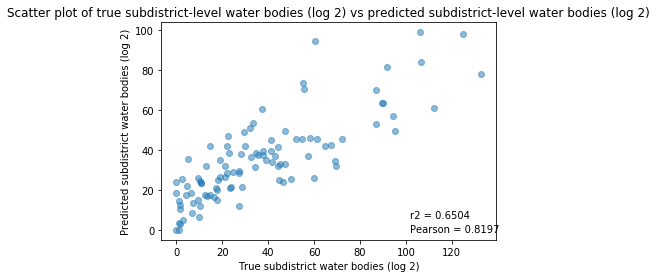

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from scipy.stats import pearsonr

plt.title("Scatter plot of true subdistrict-level water bodies (log 2) vs predicted subdistrict-level water bodies (log 2)")
plt.ylabel("Predicted subdistrict water bodies (log 2)")
plt.xlabel("True subdistrict water bodies (log 2)")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.4f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.4f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

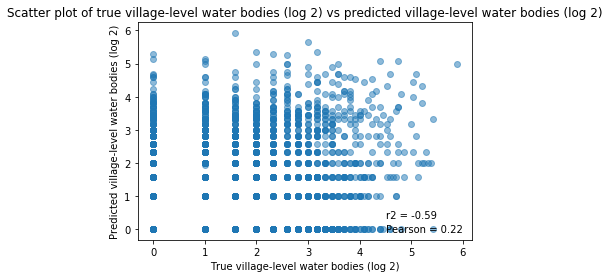

rmse: 1.68179278489
mae: 1.287750944


In [97]:
plt.title("Scatter plot of true village-level water bodies (log 2) vs predicted village-level water bodies (log 2)")
plt.ylabel("Predicted village-level water bodies (log 2)")
plt.xlabel("True village-level water bodies (log 2)")
r2 = r2_score(images_val_y_vecs, y_pred_val)
p = pearsonr(images_val_y_vecs, y_pred_val)[0]
plt.figtext(0.7, 0.2, "r2 = %.2f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.2f" % p)
plt.scatter(images_val_y_vecs, y_pred_val, alpha=0.5)
plt.show()

mse = mean_squared_error(images_val_y_vecs, y_pred_val)
print("rmse:", np.sqrt(mse))

mse = mean_absolute_error(images_val_y_vecs, y_pred_val)
print("mae:", mse)